# Normalization Curves in Uniform-grid Spatial R-Fields

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from NrnResponse import *
from NSclasses import *
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
#import seaborn as sns

In [2]:
def plot_2D(data_info,title,input_label,output_label,axis_bounds=None,xscale=None,yscale=None):

    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.xticks(fontsize=12, rotation=0)
    plt.yticks(fontsize=12, rotation=0)

    for info_cache in data_info:
        plt.plot(info_cache[0][0],info_cache[0][1],info_cache[1],label=info_cache[2],linewidth=1.5,markersize=3)

    plt.title(title,fontsize=24)
    plt.xlabel(input_label,fontsize=20)
    plt.ylabel(output_label,fontsize=20)
    if not axis_bounds == None:
        plt.axis(axis_bounds)
    if not xscale == None:
        plt.xscale(xscale)
    if not yscale == None:
        plt.yscale(yscale)
    plt.legend(loc='best',fontsize=14)
    plt.show()
    
def PlotUniformGrid(num, neurons):
    #Plot receptive fields of neurons in a uniform grid set-up
    assert(len(neurons) == num**2)
    neuron_im = [0]*(num**2)
    
    for i in range(num):
        for j in range(num):
            neuron_im[i+j*num] = neurons[i+j*num].PosCurve()
            
    fig = plt.figure(figsize=(10, 10))
    plt.title('Uniform-grid Spatial R-Fields for {} neurons'.format(num**2), 
              fontsize = 16)
    plt.axis('off')
    
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
             nrows_ncols=(num, num),  # creates grid of axes
             axes_pad=0.3,  # pad between axes in inch.
             share_all = True,
             )
    for ax, im in zip(grid, neuron_im):
        # Iterating over the grid returns the Axes.
        ax.imshow(im, extent = [-1, 1, -1, 1], aspect='auto')

    plt.show()


# Normalization model
$$
R = \gamma \frac{I^{n}}{\sigma^{n} + I^{n}_m + I^{n}}
$$

In [5]:
def initialization(nodes, flag = 0):
    assert(nodes >= 5)
    
    Grid = Mygrid(1, 1, 50, 50)
    Tar = MyNrn(0, 0, np.pi/2, Grid)
    Stimu = MyPtStm(0.1, -0.1, np.pi/2-0.1) #slight offset from target
    #Xgrid and Ygrid within [-1, 1]x[-1, 1] 
    
    #cell distance = 1/(nodes-1)
    Xspace = np.linspace(-1+0.5, 1-0.5, num=nodes, endpoint=True)
    Yspace = np.linspace(-1+0.5, 1-0.5, num=nodes, endpoint=True)
    
    #Xspace = np.delete(Xspace, np.where(abs(Xspace-Tar.x) < 0.2))
    #Yspace = np.delete(Yspace, np.where(abs(Yspace-Tar.y) < 0.2))
    
    Neurons = [0]*(nodes**2)
    Res = [0]*(nodes**2)
    
    for i in range(nodes):
        for j in range(nodes):
            x = Xspace[i]
            y = Yspace[j]
            Neurons[i+j*nodes] = MyNrn(x, y, 
                                             (i+j*nodes)*np.pi/(nodes**2), Grid)
            Res[i+j*nodes] = NrnResponse(Neurons[i+j*nodes], Stimu, Grid)
            
    ini =  NrnResponse(Tar, Stimu, Grid)
    ini_m = sum(Res)
    
    if (flag == 1):
        PlotUniformGrid(nodes, Neurons)
    else:
        print(ini, ini_m)
        return ini, ini_m
initialization(10)



0.1111111111111111
2.313120064932713 37.69341441293043


(2.313120064932713, 37.69341441293043)

In [4]:
def NormalizedR(ini, ini_m, gamma = 1, sigma = 0, exp = 1):
    nom = ini**exp
    denom = sigma**exp + ini_m**exp + nom
    return gamma* (nom/denom)

def GammaVar(gamma, N):
    ini, ini_m = initialization(N)
    return NormalizedR(ini, ini_m, gamma, 0, 1)

def SigmaVar(sigma, N):
    ini, ini_m = initialization(N)
    return NormalizedR(ini, ini_m, 1, sigma, 1)

def expVar(exp, N):
    ini, ini_m = initialization(N)
    return NormalizedR(ini, ini_m, 1, 0, exp)


In [42]:
#DataFrame set-up
N = 10
h_gam = 0.5
h_sig = 1.
h_exp = 0.1
ini, ini_m = initialization(N)
# 1 <= gamma <= 3
gamma = np.arange(1,3+h_gam, h_gam)
# 0 <= sigma <= 5
sigma = np.arange(0,5+h_sig, h_sig)
# 1 <= exp <= 3
exp = np.arange(1,3+h_exp, h_exp)
exp = np.round(exp,2)
res = dict()
rows = len(exp)*len(sigma)*len(gamma)

cols = np.zeros((rows, 6))
cols[:,3] = [ini]*rows
cols[:,4] = [ini_m]*rows

for j in range(len(sigma)):
    for k in range(len(exp)):
        for i in range(len(gamma)):
            cols[i*len(sigma)*len(exp)+j*len(exp)+k, 0] = exp[k]
            cols[i*len(sigma)*len(exp)+j*len(exp)+k, 2] = gamma[i]
            cols[i*len(sigma)*len(exp)+j*len(exp)+k, 1] = sigma[j]
            cols[i*len(sigma)*len(exp)+j*len(exp)+k, 5] = NormalizedR(ini, ini_m, 
                                                                      gamma[i], sigma[j], exp[k])
        
res['exp'] = cols[:,0]
res['sig'] = cols[:,1]
res['gam'] = cols[:,2]
res['Tar'] = cols[:,3]
res['Pool'] = cols[:,4]
res['Norm'] = cols[:,5]

df = pd.DataFrame(data = res)


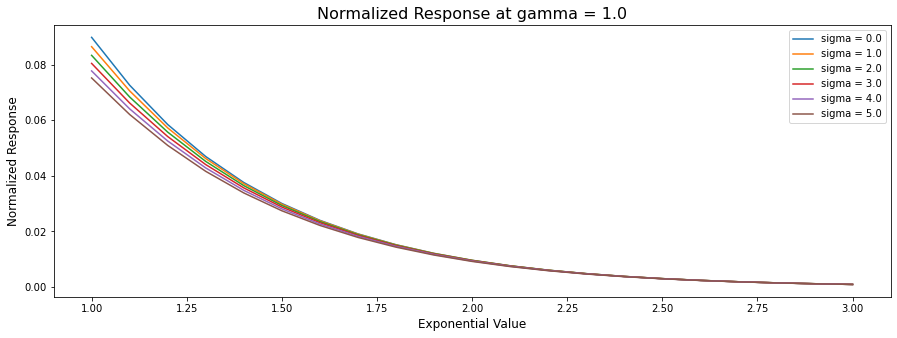

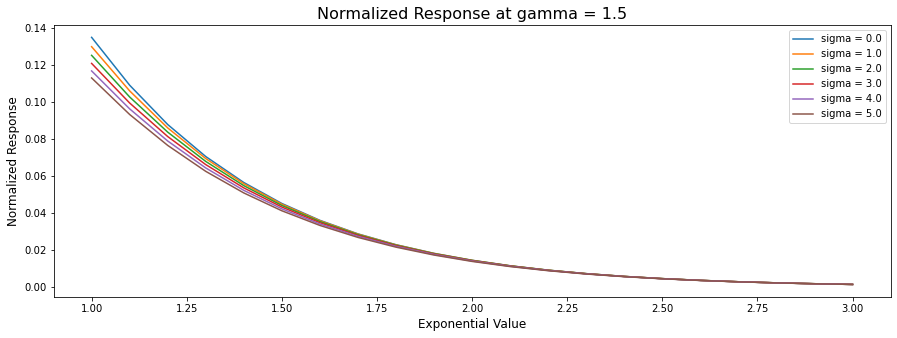

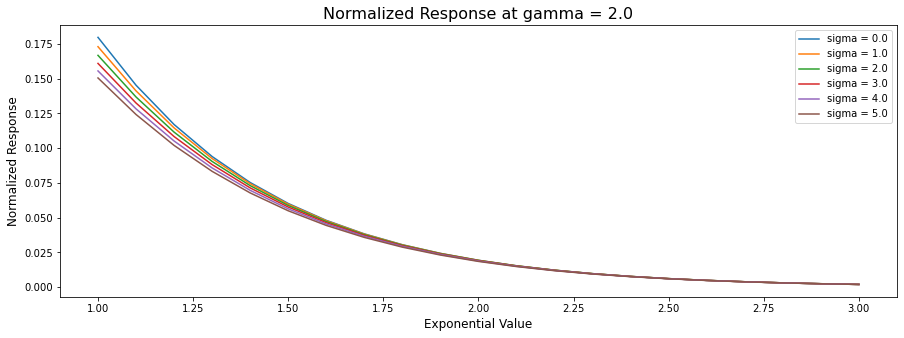

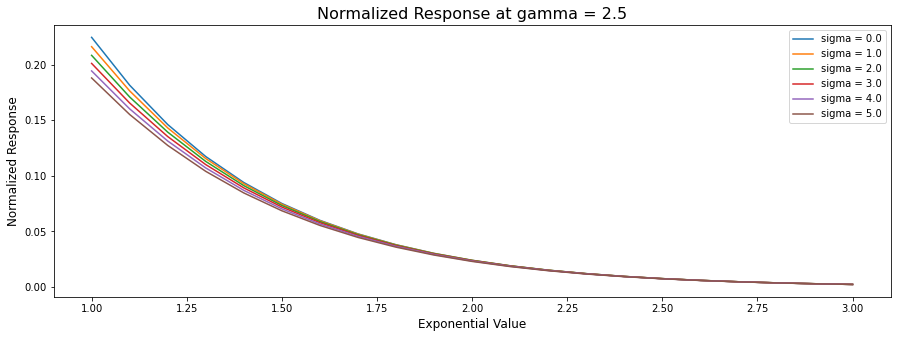

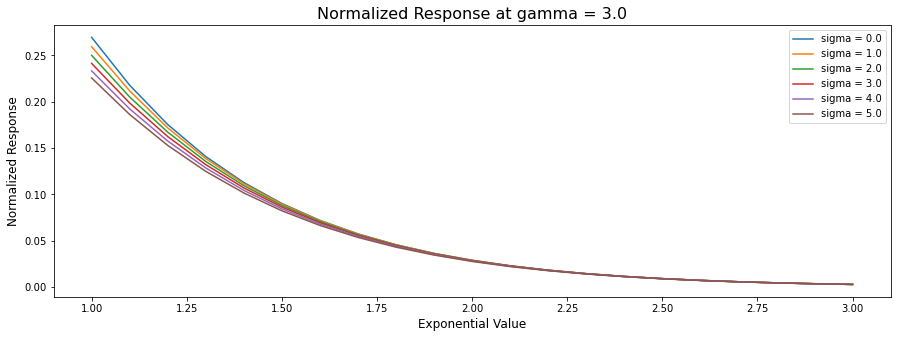

In [43]:
#use df[(df['sig'] == s) & (df['gam'] == g)] to extract values
def PlotNormalized(data, g, sigma, exp):
    #plot normalized response value with fixed gamma
    #changing sigma and exponential
    fig = plt.figure(figsize=(15, 5))
    labels = []
    for s in sigma:
        temp = data[(data['sig'] == s) & (data['gam'] == g)]
        plt.plot(temp.exp, temp.Norm)
        labels.append('sigma = {}'.format(s))
        plt.legend(labels)

        plt.xlabel('Exponential Value', fontsize = 12)
        plt.ylabel('Normalized Response', fontsize = 12)
        plt.title('Normalized Response at gamma = {}'.format(g), fontsize = 16)
        plt.show

for g in gamma:
    PlotNormalized(df, g, sigma, exp)

Created by: Ricky Huang